## Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
import torch
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils import data as D
import torch
from PIL import Image
import os
import glob
import os.path as osp

## mount

In [ ]:

from google.colab import drive;
drive.mount("/content/gdrive");

Mounted at /content/gdrive


## dataset loading

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/soft_ass2/training-a.csv");
print(df.head());

     filename           original filename  ...  contributing team  database name
0  a00000.png   Scan_58_digit_5_num_8.png  ...       Buet_Broncos     training-a
1  a00001.png   Scan_73_digit_3_num_5.png  ...       Buet_Broncos     training-a
2  a00002.png   Scan_18_digit_1_num_3.png  ...       Buet_Broncos     training-a
3  a00003.png  Scan_166_digit_7_num_3.png  ...       Buet_Broncos     training-a
4  a00004.png  Scan_108_digit_0_num_1.png  ...       Buet_Broncos     training-a

[5 rows x 7 columns]


## Drop columns except filename and digit

In [ ]:
modified_df = df.drop(['original filename', 'scanid', 'database name original', 'database name', 'contributing team'], axis =1)
print(modified_df);
print(len(modified_df));

         filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]
19702


## hyperparams

In [ ]:
batch_size = 20;
num_iters = 20000;
input_dim = 180 * 180; #num_features = 32400
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 6;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cpu


## dataset path


In [ ]:
path = '/content/gdrive/MyDrive/soft_ass2/training-a';

## dataset preprocessing

In [ ]:
class imageDataset(D.Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

## normalize

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


## return the pre processed dataset

In [ ]:
full_dataset  = imageDataset(modified_df, path, train_transform)


## train test split

In [ ]:
dataset_size = len(full_dataset);
print(dataset_size);
indices = list(range(dataset_size));
train_dataset_len = int(np.floor(0.8 * dataset_size))
print(train_dataset_len);
test_dataset_len = dataset_size - train_dataset_len;
print(test_dataset_len);
train_dataset, test_dataset = D.random_split(full_dataset, lengths=[train_dataset_len, test_dataset_len]);
print(train_dataset);
print(test_dataset);


19702
15761
3941


## dataloader  which combines samples and data providing iterable characteristic

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

print(num_epochs)

25


## ELU  (Exponential Linear Units)

In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.elu_1 = nn.ELU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_2 = nn.ELU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_3 = nn.ELU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_4 = nn.ELU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.elu_5= nn.ELU()
 
         
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_6 = nn.ELU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.elu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.elu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.elu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.elu_4(out)
 
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.elu_5(out)
 
        out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        out = self.elu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 


 


## INSTANTIATE MODEL CLASS

In [ ]:

 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (elu_1): ELU(alpha=1.0)
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (elu_2): ELU(alpha=1.0)
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (elu_3): ELU(alpha=1.0)
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (elu_4): ELU(alpha=1.0)
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (elu_5): ELU(alpha=1.0)
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (elu_6): ELU(alpha=1.0)
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

## INSTANTIATE LOSS & OPTIMIZER CLASS

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## train model

In [ ]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3016304969787598. Accuracy: 11.748287236741943
Iteration: 1000. Loss: 2.296922206878662. Accuracy: 13.702106064450646
Iteration: 1500. Loss: 2.2170794010162354. Accuracy: 10.936310581070794
Iteration: 2000. Loss: 2.162860870361328. Accuracy: 15.249936564323775
Iteration: 2500. Loss: 2.0085506439208984. Accuracy: 16.163410301953817
Iteration: 3000. Loss: 1.8649206161499023. Accuracy: 19.893428063943162
Iteration: 3500. Loss: 1.9856064319610596. Accuracy: 20.654656178634863
Iteration: 4000. Loss: 1.9234259128570557. Accuracy: 22.5323521948744
Iteration: 4500. Loss: 2.1054835319519043. Accuracy: 25.019030702867294
Iteration: 5000. Loss: 2.3017163276672363. Accuracy: 26.5414869322507
Iteration: 5500. Loss: 1.7317508459091187. Accuracy: 25.881755899517888
Iteration: 6000. Loss: 1.7212960720062256. Accuracy: 30.652118751585892
Iteration: 6500. Loss: 2.006653070449829. Accuracy: 27.07434661253489
Iteration: 7000. Loss: 1.8924171924591064. Accuracy: 32.45369195635625
It

## loss values over iterations

In [ ]:
loss_exp_given_batch =[2.3016304969787598,2.296922206878662,2.170794010162354,2.162860870361328,2.0085506439208984,1.8649206161499023,
                       1.9856064319610596,1.9234259128570557,2.1054835319519043,2.3017163276672363,1.7317508459091187,1.7212960720062256,2.006653070449829,1.8924171924591064,
                       1.9954153299331665,1.8126815557479858,1.6413888931274414,1.7602827548980713,2.0520102977752686,2.236318349838257,1.3804515600204468,1.6982606649398804,
                       1.422581672668457,1.3073225021362305,1.3768157958984375,1.3768157958984375,1.494845986366272,1.4616364240646362,1.6724334955215454,1.319594144821167,1.5324022769927979,
                       1.910794973373413,1.7086082696914673,1.8724994659423828,1.1475602388381958,1.6813043355941772,1.3400057554244995,1.5343211889266968,1.654476523399353
                       ]
print(len(loss_exp_given_batch))

39


In [ ]:
iterations = list(range(500,20000,500));
print(len(iterations));

39


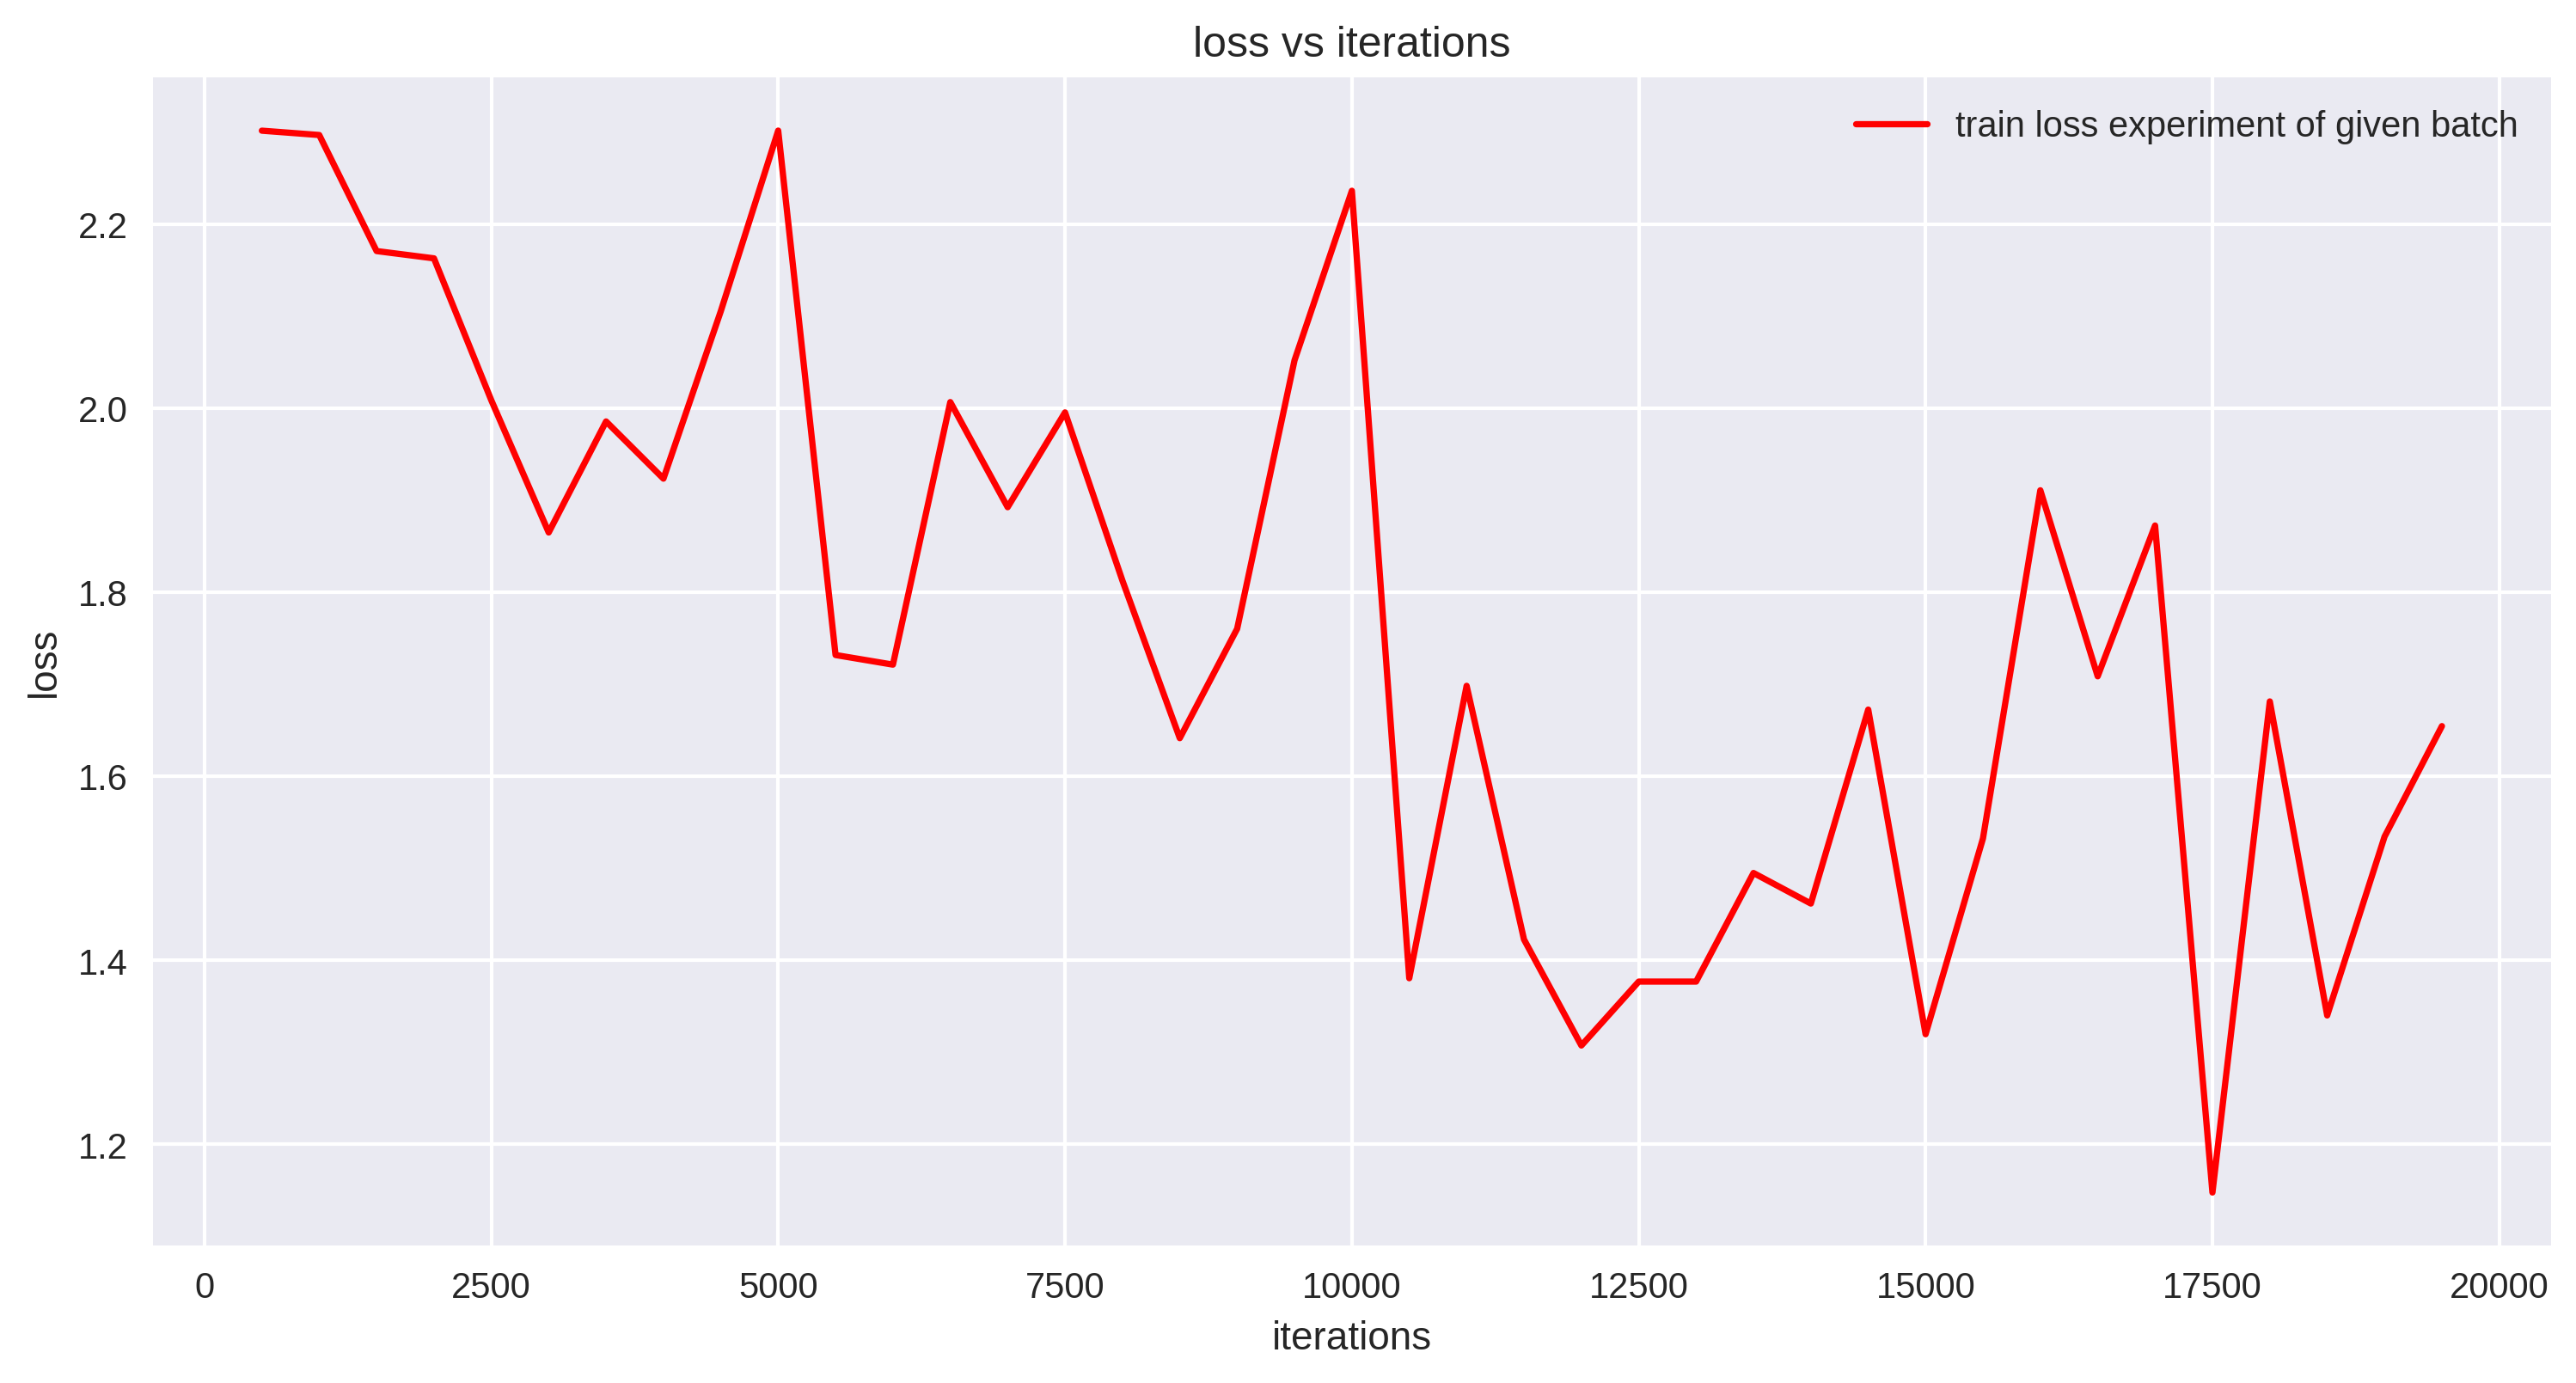

In [ ]:
plt.figure(figsize=(12,6),dpi=300);
plt.style.use('seaborn');
plt.plot(iterations, loss_exp_given_batch, color='red',label='train loss experiment of given batch');
##plt.plot(iterations, loss_exp_2, color='blue',label='train loss of experiment 2');
plt.title('loss vs iterations');
plt.xlabel('iterations');
plt.ylabel('loss');
plt.grid(True); #create a grid layout
plt.legend();
plt.show()

## Experiment #2

In [ ]:
batch_size = 110;
num_iters = 30500;
input_dim = 180 * 180; #num_features = 32400
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 4;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cpu


## Preprocessing

In [ ]:
class imageDataset(D.Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

## normalize

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


## returns the dataset

In [ ]:
full_dataset  = imageDataset(modified_df, path, train_transform)

## train test split

In [ ]:
dataset_size = len(full_dataset);
print(dataset_size);
indices = list(range(dataset_size));
train_dataset_len = int(np.floor(0.8 * dataset_size))
print(train_dataset_len);
test_dataset_len = dataset_size - train_dataset_len;
print(test_dataset_len);
train_dataset, test_dataset = D.random_split(full_dataset, lengths=[train_dataset_len, test_dataset_len]);
print(len(train_dataset));
print(len(test_dataset));


19702
15761
3941
15761
3941


## dataloader

In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

print(len(train_loader));
print(len(test_loader));

144
36


## ELU for Experiment#2

In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.elu_1 = nn.ELU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_2 = nn.ELU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_3 = nn.ELU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_4 = nn.ELU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.elu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.elu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.elu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.elu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 


 


## INSTANTIATE MODEL CLASS

In [ ]:

 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (elu_1): ELU(alpha=1.0)
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (elu_2): ELU(alpha=1.0)
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (elu_3): ELU(alpha=1.0)
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (elu_4): ELU(alpha=1.0)
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

## INSTANTIATE LOSS & OPTIMIZER CLASS

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## train model

In [ ]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.256736159324646. Accuracy: 52.01725450393301
Iteration: 1000. Loss: 1.436526894569397. Accuracy: 48.00811976655671
Iteration: 1500. Loss: 1.0247042179107666. Accuracy: 57.777213905100226
Iteration: 2000. Loss: 1.1544082164764404. Accuracy: 56.812991626490735
Iteration: 2500. Loss: 1.0082635879516602. Accuracy: 53.79345343821365
Iteration: 3000. Loss: 1.2361211776733398. Accuracy: 56.43237756914489
Iteration: 3500. Loss: 1.0471206903457642. Accuracy: 61.101243339254
Iteration: 4000. Loss: 0.993796169757843. Accuracy: 56.43237756914489
Iteration: 4500. Loss: 1.2003360986709595. Accuracy: 59.832529814767824
Iteration: 5000. Loss: 1.0227978229522705. Accuracy: 62.97893935549353
Iteration: 5500. Loss: 0.7422497272491455. Accuracy: 59.90865262623699
Iteration: 6000. Loss: 0.9134693741798401. Accuracy: 62.217711240801826
Iteration: 6500. Loss: 0.8924381136894226. Accuracy: 65.38949505201725
Iteration: 7000. Loss: 0.9884812831878662. Accuracy: 61.304237503171784
Iterati

In [ ]:
loss_exp_2 = [1.256736159324646,1.436526894569397,1.0247042179107666,1.1544082164764404,1.0082635879516602,1.2361211776733398,
1.0471206903457642,0.993796169757843,1.2003360986709595,1.0227978229522705,0.7422497272491455,0.9134693741798401,0.8924381136894226,0.9884812831878662,0.8806325197219849,0.838342547416687,1.0457706451416016,
0.8639861941337585,0.8416787385940552,0.7726564407348633,0.8604705929756165,0.8343972563743591,0.8127405047416687,0.8054249882698059,0.8925833106040955,0.5295506119728088,0.7460058927536011,0.9630224108695984,
0.6819326281547546,0.8003407120704651,0.6778143644332886,0.7484490275382996,0.7952001690864563,0.6204280257225037,0.8875100016593933,0.5188421010971069,0.6910868287086487,0.698046088218689,0.5443669557571411,
0.5500456094741821,0.7101061940193176,0.6523411273956299,0.4829542934894562,0.4752271771430969,0.5083264708518982,0.44498002529144287,0.6256938576698303,0.8228164911270142,0.5329247713088989,0.5850523114204407, 
0.41088131070137024,0.60825514793396,0.5242359638214111,0.5793244242668152,0.5034852027893066,0.5384088754653931,0.5174182653427124,0.6444612741470337,0.5598291754722595,0.31540635228157043,0.356425940990448 
]
print(len(loss_exp_2))

61


In [ ]:
iterations = list(range(500,31000,500));
print(len(iterations));

61


## loss vs iterations

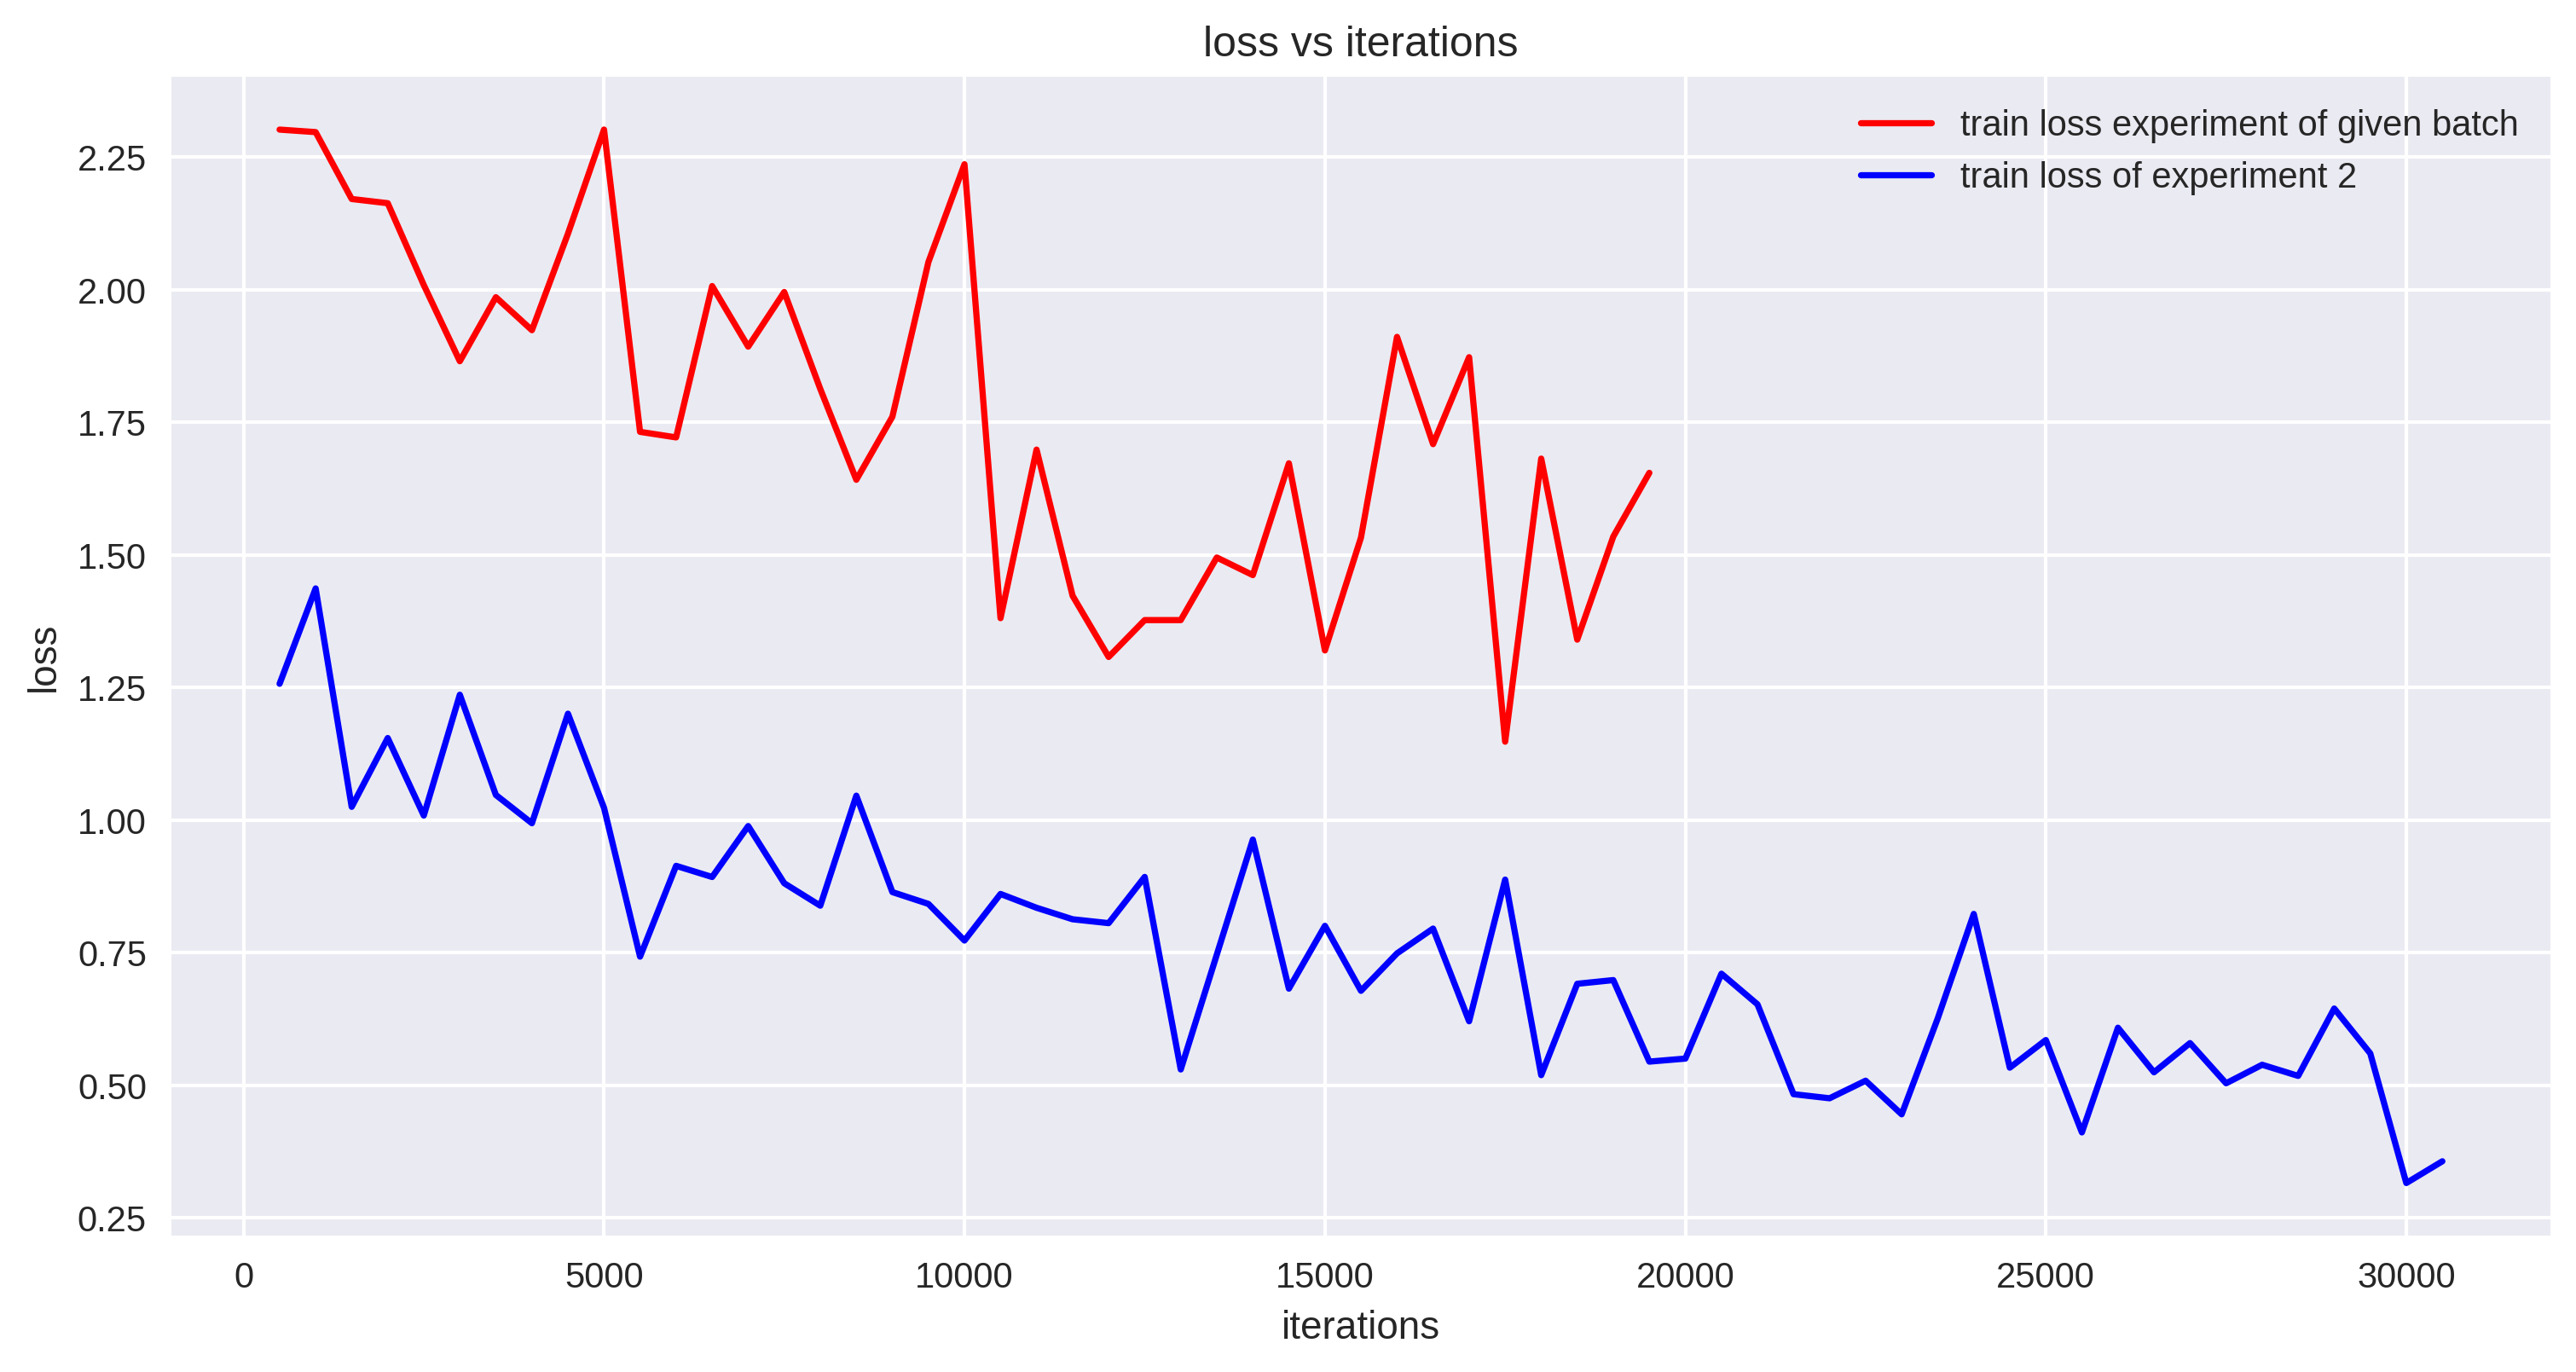

In [ ]:
plt.figure(figsize=(12,6),dpi=300);
plt.style.use('seaborn');
plt.plot(iterations[0:39], loss_exp_given_batch, color='red',label='train loss experiment of given batch');
plt.plot(iterations, loss_exp_2, color='blue',label='train loss of experiment 2');
plt.title('loss vs iterations');
plt.xlabel('iterations');
plt.ylabel('loss');
plt.grid(True); #create a grid layout
plt.legend();
plt.show()

## Dataset 2

In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/soft_ass2/Dataset_2/verification_train.csv");
print(train_df.head());

   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      2       0       0       0  ...         0         0         0         0
1      9       0       0       0  ...         0         0         0         0
2      6       0       0       0  ...         0         0         0         0
3      0       0       0       0  ...         0         0         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]


In [ ]:
test_df = pd.read_csv("/content/gdrive/MyDrive/soft_ass2/Dataset_2/verification_test.csv");
print(test_df.head());

   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      0       0       0       0  ...         0         0         0         0
1      1       0       0       0  ...         0         0         0         0
2      2       0       0       0  ...        31         0         0         0
3      2       0       0       0  ...       222        56         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math;
from matplotlib.pyplot import imshow

4
784
28
Label: 4


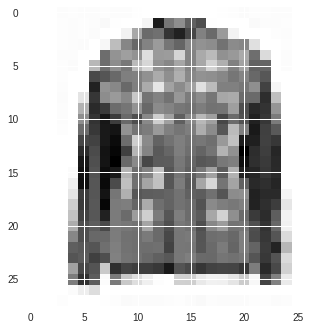

In [ ]:
i = 5 # set any valid index of an image
label = train_df.values[i][0] # retrieve label from first colum in dataframe
print(label)
im_buf = train_df.values[i][1:] # create flat array of only the pixels of the given image
print(len(im_buf)); 
axis_len = int(math.sqrt(im_buf.shape[0])) # calculate the dimensions of the square image
print(axis_len);
im_array = np.int8(np.reshape(im_buf, (axis_len, axis_len))) # create a 2D array from flat array
img = Image.fromarray(im_array, 'L') # convert to a PIL.Image object ('L' is for grayscale)

print(f'Label: {label}')
imshow(np.asarray(img))


In [ ]:
train_df['pixel12'] = train_df['pixel12'] / 255;
for i in train_df['pixel12']:
  print(i);


Streaming output truncated to the last 5000 lines.
0.8
0.19215686274509805
0.0
0.2196078431372549
0.0
0.48627450980392156
0.0
0.00392156862745098
0.0
0.0
0.0
0.0
0.0
0.011764705882352941
0.23921568627450981
0.8901960784313725
0.0
0.01568627450980392
0.1607843137254902
0.0
0.0
0.403921568627451
0.5137254901960784
0.34901960784313724
0.0
0.0
0.0
0.0
0.0
0.8117647058823529
0.0
0.0
0.0
0.8431372549019608
0.43529411764705883
0.5725490196078431
0.0
0.0
0.0
0.0
0.5490196078431373
0.15294117647058825
0.0
0.0
0.7725490196078432
0.00784313725490196
0.27450980392156865
0.058823529411764705
0.0
0.9058823529411765
0.0
0.0
0.6352941176470588
0.0
0.7490196078431373
0.5098039215686274
0.0
0.3058823529411765
0.0
0.09019607843137255
0.6627450980392157
0.0
0.41568627450980394
0.0
0.0
0.40784313725490196
0.0
0.0
0.0
0.0
0.9725490196078431
0.0
0.0
0.0
0.0
0.40784313725490196
0.5372549019607843
0.0
0.0
0.0
0.0
0.27058823529411763
0.39215686274509803
0.00392156862745098
0.0
0.40784313725490196
0.0
0.0
0.1960

## data label from dataset 2

In [ ]:
test_label=test_df['label']

train_label=train_df['label']
data_names=[test_label,train_label]
all_labels=pd.concat(data_names,ignore_index=True)
print(all_labels);

0        0
1        1
2        2
3        2
4        3
        ..
69995    9
69996    1
69997    8
69998    8
69999    7
Name: label, Length: 70000, dtype: int64


## image pixels for dataset 2

In [ ]:
data_name=[test_df,train_df]
all_image=pd.concat(data_name,ignore_index=True)
all_image=all_image.drop(labels='label',axis=1)
print(all_image.shape)
print(all_image);

(70000, 784)
       pixel1  pixel2  pixel3  pixel4  ...  pixel781  pixel782  pixel783  pixel784
0           0       0       0       0  ...         0         0         0         0
1           0       0       0       0  ...         0         0         0         0
2           0       0       0       0  ...        31         0         0         0
3           0       0       0       0  ...       222        56         0         0
4           0       0       0       0  ...         0         0         0         0
...       ...     ...     ...     ...  ...       ...       ...       ...       ...
69995       0       0       0       0  ...         0         0         0         0
69996       0       0       0       0  ...         0         0         0         0
69997       0       0       0       0  ...         0         0         0         0
69998       0       0       0       0  ...         0         0         0         0
69999       0       0       0       0  ...         0         0         0  

## normalize

In [ ]:
all_image=all_image/255.0

## reshape image

In [ ]:
all_image=all_image.values.reshape(-1,28,28,1)

##  print images

0


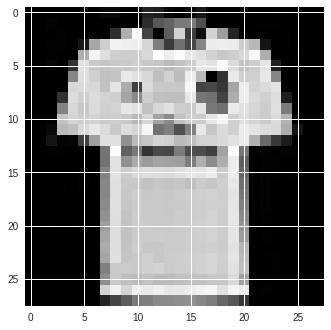

In [ ]:
show_img = all_image[0].reshape(28, 28)
plt.imshow(show_img, cmap='gray')
print(all_labels[0])

## train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_image, all_labels, test_size=0.2)

## zipped

In [ ]:
train_dataset_zipped = list(zip(X_train,y_train))
test_dataset_zipped = list(zip(X_test,y_test))
print(len(train_dataset_zipped))
print(len(test_dataset_zipped))


56000
14000


## hyperparams

In [ ]:
batch_size = 20;
num_iters = 20000;
input_dim = 28*28; #num_features = 784
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 6;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cpu


## dataloader

In [ ]:
num_epochs = num_iters / (len(train_dataset_zipped) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset_zipped, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset_zipped, 
                                          batch_size=batch_size, 
                                          shuffle=False) 
print(len(train_loader));
print(len(test_loader));

2800
700


## ELU for dataset 2

In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.elu_1 = nn.ELU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_2 = nn.ELU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_3 = nn.ELU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_4 = nn.ELU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.elu_5= nn.ELU()
 
         
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_6 = nn.ELU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.elu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.elu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.elu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.elu_4(out)
 
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.elu_5(out)
 
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.elu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

## INSTANTIATE MODEL CLASS

In [ ]:

 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (elu_1): ELU(alpha=1.0)
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (elu_2): ELU(alpha=1.0)
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (elu_3): ELU(alpha=1.0)
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (elu_4): ELU(alpha=1.0)
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (elu_5): ELU(alpha=1.0)
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (elu_6): ELU(alpha=1.0)
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

## INSTANTIATE LOSS & OPTIMIZER CLASS

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## train model

In [ ]:
Iteration_loss =[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images.float()) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images.float())
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            Iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.073577404022217. Accuracy: 31.228571428571428
Iteration: 1000. Loss: 1.2572863101959229. Accuracy: 50.878571428571426
Iteration: 1500. Loss: 0.9895681142807007. Accuracy: 59.25
Iteration: 2000. Loss: 1.0627686977386475. Accuracy: 66.74285714285715
Iteration: 2500. Loss: 0.7838900685310364. Accuracy: 73.08571428571429
Iteration: 3000. Loss: 0.8156553506851196. Accuracy: 72.39285714285714
Iteration: 3500. Loss: 0.4989476203918457. Accuracy: 74.61428571428571
Iteration: 4000. Loss: 0.6360244750976562. Accuracy: 75.71428571428571
Iteration: 4500. Loss: 0.5686893463134766. Accuracy: 74.43571428571428
Iteration: 5000. Loss: 0.4344751238822937. Accuracy: 77.02142857142857
Iteration: 5500. Loss: 0.5366503000259399. Accuracy: 78.16428571428571
Iteration: 6000. Loss: 0.7103918194770813. Accuracy: 78.85714285714286
Iteration: 6500. Loss: 0.26885172724723816. Accuracy: 79.21428571428571
Iteration: 7000. Loss: 0.4347662329673767. Accuracy: 80.41428571428571
Iteration: 7500. 

## modified hyper parmas for dataset 2 

In [ ]:
batch_size = 110;
num_iters = 30000;
input_dim = 28*28; #num_features = 784
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 4;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cpu


## dataloader

In [ ]:
num_epochs = num_iters / (len(train_dataset_zipped) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset_zipped, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset_zipped, 
                                          batch_size=batch_size, 
                                          shuffle=False) 
print(len(train_loader));
print(len(test_loader));

510
128


## ELU for modified data

In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.elu_1 = nn.ELU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_2 = nn.ELU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_3 = nn.ELU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.elu_4 = nn.ELU()
         
        self.linear_out = nn.Linear(num_hidden, num_classes)
 

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.elu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.elu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.elu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.elu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

## INSTANTIATE MODEL CLASS

In [ ]:

 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (elu_1): ELU(alpha=1.0)
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (elu_2): ELU(alpha=1.0)
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (elu_3): ELU(alpha=1.0)
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (elu_4): ELU(alpha=1.0)
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

## INSTANTIATE LOSS & OPTIMIZER CLASS

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## train model updated hyperparams

In [ ]:
Iteration_loss1 =[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images.float()) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images.float())
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            Iteration_loss1.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.453023076057434. Accuracy: 53.80714285714286
Iteration: 1000. Loss: 0.8141860961914062. Accuracy: 64.55
Iteration: 1500. Loss: 0.7074819207191467. Accuracy: 73.34285714285714
Iteration: 2000. Loss: 0.627366304397583. Accuracy: 76.13571428571429
Iteration: 2500. Loss: 0.6525856256484985. Accuracy: 77.26428571428572
Iteration: 3000. Loss: 0.7868732213973999. Accuracy: 79.77857142857142
Iteration: 3500. Loss: 0.6039386987686157. Accuracy: 80.48571428571428
Iteration: 4000. Loss: 0.5242433547973633. Accuracy: 80.9
Iteration: 4500. Loss: 0.4104524850845337. Accuracy: 81.9
Iteration: 5000. Loss: 0.46186327934265137. Accuracy: 82.40714285714286
Iteration: 5500. Loss: 0.4362432360649109. Accuracy: 82.63571428571429
Iteration: 6000. Loss: 0.6226527690887451. Accuracy: 83.05714285714286
Iteration: 6500. Loss: 0.48381224274635315. Accuracy: 82.94285714285714
Iteration: 7000. Loss: 0.4212248921394348. Accuracy: 83.40714285714286
Iteration: 7500. Loss: 0.4868374764919281. Ac

In [ ]:
iterations = list(range(500,30000,500));
print(len(iterations));

59


## loss vs iterations

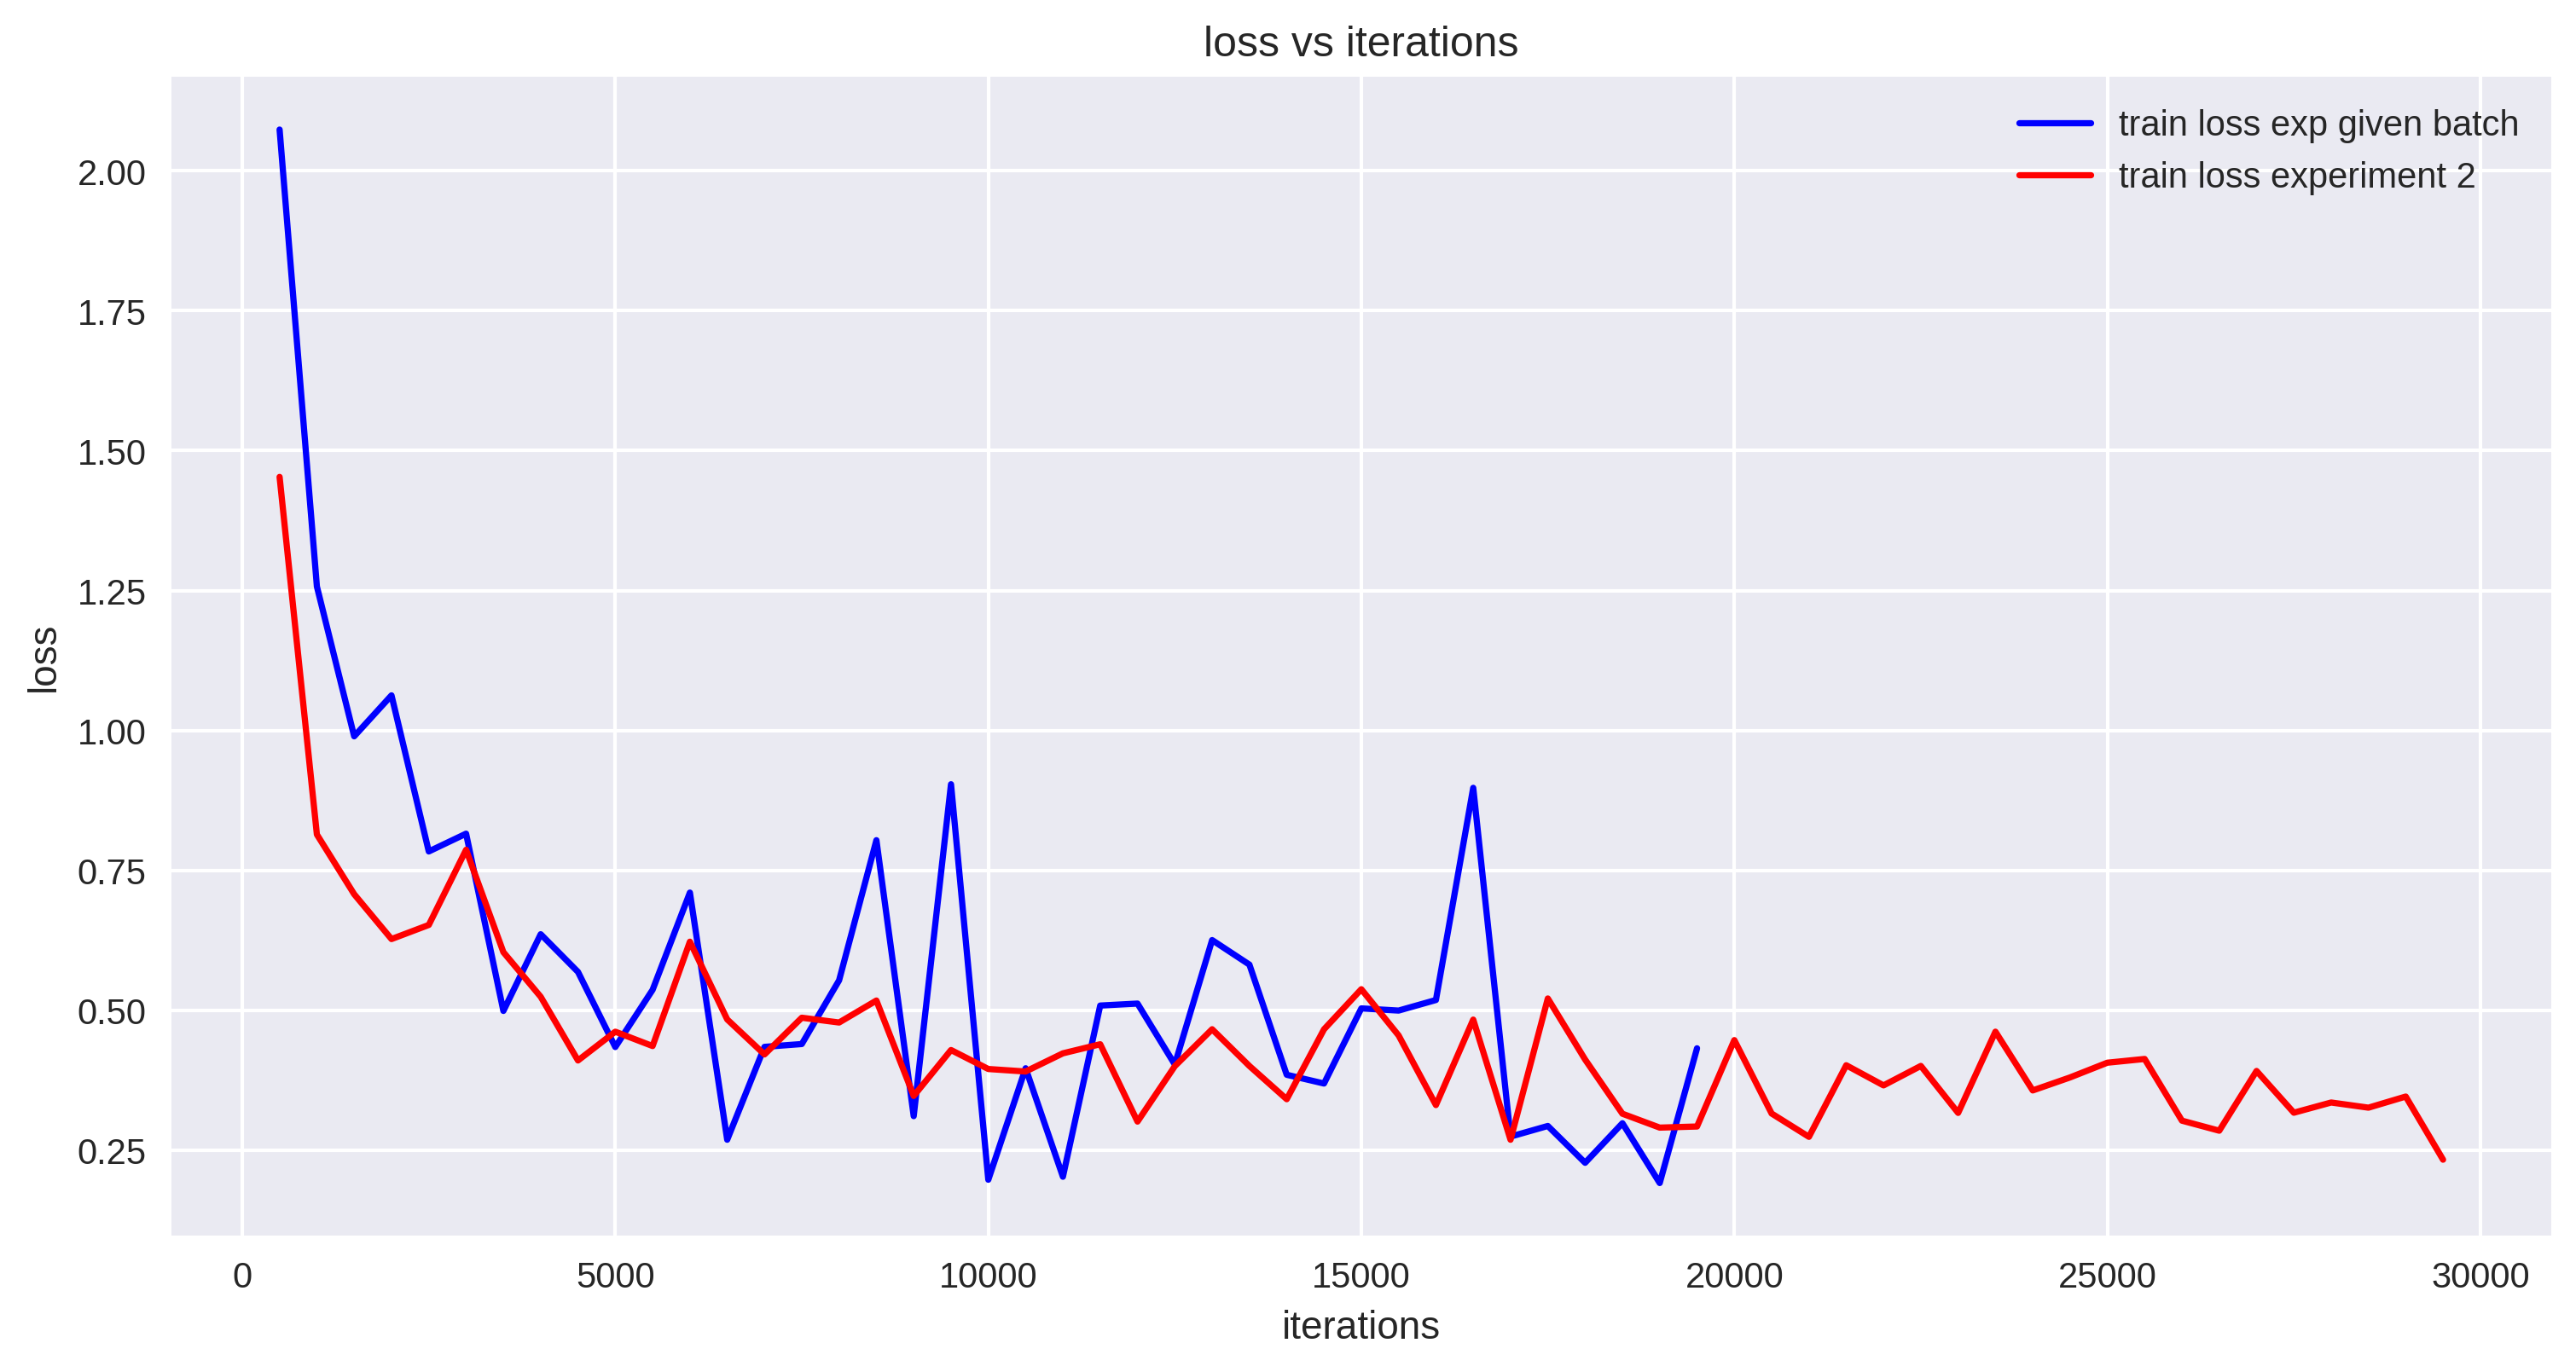

In [ ]:
plt.figure(figsize=(12,6),dpi=300);
plt.style.use('seaborn');
plt.plot(iterations[0:39] , Iteration_loss, color='blue',label='train loss exp given batch');
plt.plot(iterations , Iteration_loss1, color='red',label='train loss experiment 2');
plt.title('loss vs iterations');
plt.xlabel('iterations');
plt.ylabel('loss');
plt.grid(True); #create a grid layout
plt.legend();
plt.show()

## The end of colab



In [ ]:
print("Doumo Arigatou. Sayounara");

Doumo Arigatou. Sayounara
